In [ ]:
# Paper: Beyond Accuracy: Behavioral Testing of NLP Models with CheckList ACL 2020

# One sentence summary:
# Method to test the behaviour of NLP models through different experiments on small
# manufactured example test sets.

# Criticism:
# The authors focus mainly on English NLP models and show that the CheckList analyses
# uncover errors in commercial and openly available models. However, there is a wide usage
# of multilingual models in the NLP community for multilingual or low-resource experiments
# which makes an error analysis of multilingual models relevant and interesting.

# Planned Implementation:
# The plan is to take a multilingual model (e.g., mBERT) and create a Minimum Functionality
# Test (MFT) for testing how the model handles negations in parallel Sentiment Analysis
# sentences in English (like "It was bad.", "It was good.", "It was not good."), German ("Es war
# schlecht.", "Es war gut.", "Es war nicht gut.") and Bavarian ("Des war schlecht.", "Des war
# guad.", "Des war ned guad."). The experiments should then show whether the CheckList
# methods can also be used in a multilingual setup and whether mBERT's behaviour changes
# for different languages.

# Feedback:
# The proposal extends CheckList to other languages and implements a Minimum Functionality Test comparing English, German and Bavarian.
# Looks good. Approved.

In [ ]:
# research questions:
# can CheckList be applied to multilingual models? (only tested on English models)
# can CheckList be used to compare model capabilities across languages? (here: has the model different behaviour when handling negations in different languages)

In [ ]:
# sources

# code for data creation partly taken from 
# https://github.com/marcotcr/checklist/blob/master/notebooks/tutorials/1.%20Generating%20data.ipynb
# with major changes

# code for test creation and execution partly taken from
# https://github.com/marcotcr/checklist/blob/master/notebooks/tutorials/3.%20Test%20types%2C%20expectation%20functions%2C%20running%20tests.ipynb and
# https://github.com/marcotcr/checklist/blob/master/notebooks/tutorials/4.%20The%20CheckList%20process.ipynb
# with minor changes

# code for model training taken partly from 
# https://huggingface.co/blog/sentiment-analysis-python
# with minor changes

# code for visualisation

In [ ]:
# notes
# hard to find adjective pairs where standard German and Bavarian are different -> focus on only three pairs per sentiment

# test sentences only work with predicative adjective constructions to avoid issues with inflection of the pre-chosen adjectives in standard German and Bavarian

In [1]:
import MultilingualCheckList.multi_checklist as multi_checklist
from checklist.editor import Editor
from checklist.test_types import MFT
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# initialise CheckList Editor objects
eng_editor = Editor() # default language is English
deu_editor = Editor(language="german")

## Create Data

In [5]:
# get adj suggestions from the CheckList Editors in German and English
print("English adj suggestions: ")
print(eng_editor.suggest("This is a {mask} {noun}.", noun=["book", "movie"])[:20], "\n") 

print("German adj suggestions: ")
print(deu_editor.suggest("Das ist ein {mask} Buch.")[:20]) 
print(deu_editor.suggest("Das ist ein {mask} Film.")[:20])

English adj suggestions: 
['great', 'good', 'wonderful', 'beautiful', 'fantastic', 'terrible', 'fascinating', 'big', 'nice', 'bad', 'long', 'fun', 'scary', 'terrific', 'tough', 'short', 'serious', 'huge', 'remarkable', 'new'] 

German adj suggestions: 
['gutes', 'neues', 'großes', 'kleines', 'starkes', 'politisches', 'anderes', 'wichtiges', 'ganzes', 'besonderes', 'altes', 'deutsches', 'eigenes', 'super', 'weiteres', 'solches', 'zweites', 'einziges', 'letztes', 'erstes']
['guter', 'schlechter', 'großer', 'schöner', 'super', 'wichtiger', 'deutscher', 'schwieriger', 'historischer', 'neuer', 'kleiner', 'politischer', 'typischer', 'anderer', 'besonderer', 'amerikanischer', 'klassischer', 'einfacher', 'internationaler', 'langer']


In [3]:
# parallel adjective lists for data creation
eng_pos = ["good", "nice", "great"]
deu_pos = ["gut", "schön", "super"]
bar_pos = ["guad", "schee", "subba"]

eng_neg = ["bad", "boring", "stupid"]
deu_neg = ["schlecht", "langweilig", "blöd"]
bar_neg = ["schlecht", "fad", "bled"]

In [9]:
# get noun suggestions from the CheckList Editors in German and English
# english suggestions
print("English noun suggestions: ")
print(eng_editor.suggest("This {mask} is {pos}.", pos=eng_pos)[:10]) 
print(eng_editor.suggest("This {mask} is {neg}.", neg=eng_neg)[:10], "\n") 

# suggestions for standard German with different determiners
print("German noun suggestions: ")
print("Der", deu_editor.suggest("Der {mask} ist {pos}.", pos=deu_pos)[:10])
print("Der", deu_editor.suggest("Der {mask} ist {neg}.", neg=deu_neg)[:10])
print("Die", deu_editor.suggest("Die {mask} ist {pos}.", pos=deu_pos)[:10])
print("Die", deu_editor.suggest("Die {mask} ist {neg}.", neg=deu_neg)[:10])
print("Das", deu_editor.suggest("Das {mask} ist {pos}.", pos=deu_pos)[:10])
print("Das", deu_editor.suggest("Das {mask} ist {neg}.", neg=deu_neg)[:10])

English noun suggestions: 
['game', 'one', 'stuff', 'book', 'article', 'video', 'post', 'movie', 'code', 'thing']
['post', 'article', 'game', 'stuff', 'video', 'movie', 'list', 'shit', 'thing', 'book'] 

German noun suggestions: 
Der ['Preis', 'Job', 'Platz', 'Service', 'Abend', 'Wind', 'Rest', 'Sieg', 'Auftritt', 'Eindruck']
Der ['Rest', 'Job', 'Film', 'Ton', 'Fußball', 'Mann', 'Preis', 'Markt', 'Anfang', 'Fall']
Die ['Stimmung', 'Atmosphäre', 'Situation', 'Sache', 'Resonanz', 'Lage', 'Idee', 'Antwort', 'Qualität', 'Zusammenarbeit']
Die ['Stimmung', 'Sache', 'Situation', 'Lage', 'Welt', 'Idee', 'Musik', 'Antwort', 'Geschichte', 'Zeit']
Das ['Ergebnis', 'Wetter', 'alles', 'Leben', 'Angebot', 'hier', 'Spiel', 'Resultat', 'Stadion', 'Essen']
Das ['Ergebnis', 'alles', 'Wetter', 'Leben', 'aber', 'Spiel', 'Ganze', 'hier', 'Auto', 'Geschäft']


In [4]:
# parallel noun lists for data creation
# picked from Editor suggestions in such a way that mostly all words are different
eng_noun = ["game", "site", "picture", "book", "story", "man", "world", "city", "time", "weather", "life"]

# standard German and Bavarian examples with determiners to avoid errors
deu_noun = [
    ("Das", "Spiel"), ("Die", "Seite"), ("Das", "Bild"), ("Das", "Buch"), ("Die", "Geschichte"), 
    ("Der", "Mann"), ("Die", "Welt"), ("Die", "Stadt"), ("Die", "Zeit"), ("Das", "Wetter"), ("Das", "Leben")
    ]

# bavarian determiners are with spaces to handle "d'" and "s'" determiners
bar_noun = [
    ("Des ", "Spui"), ("De ", "Seitn"), ("Des ", "Buidl"), ("Des ", "Buach"), ("De ", "Gschicht"), 
    ("Der ", "Mo"), ("D'", "Weid"), ("D'", "Stod"), ("D'", "Zeid"), ("S'", "Weda"), ("S'", "Lebm")
    ] 

In [5]:
# create english data
eng = eng_editor.template("The {noun} is not {adj}.", noun=eng_noun, adj=eng_pos, labels=0) # not pos = negative
eng += eng_editor.template("The {noun} is not {adj}.", noun=eng_noun, adj=eng_neg, labels=2) # not neg = positive

# create german data
deu = deu_editor.template("{detnoun[0]} {detnoun[1]} ist nicht {adj}.", detnoun=deu_noun, adj=deu_pos, labels=0)
deu += deu_editor.template("{detnoun[0]} {detnoun[1]} ist nicht {adj}.", detnoun=deu_noun, adj=deu_neg, labels=2)

# create bavarian data
bar = deu_editor.template("{detnoun[0]}{detnoun[1]} is ned {adj}.", detnoun=bar_noun, adj=bar_pos, labels=0)
bar += deu_editor.template("{detnoun[0]}{detnoun[1]} is ned {adj}.", detnoun=bar_noun, adj=bar_neg, labels=2)

## Run Tests

In [6]:
# initialise minimum functionality tests
eng_test = MFT(**eng, name="English Negations", capability="Negation", description="Litotes sentences to test negation capabilities.")
deu_test = MFT(**deu, name="Standard German Negations", capability="Negation", description="Litotes sentences to test negation capabilities.")
bar_test = MFT(**bar, name="Bavarian Negations", capability="Negation", description="Litotes sentences to test negation capabilities.")

In [8]:
# load finetuned mBERT for sentiment analysis
model_name = "mi-winkler/SentiMBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# initialise pipeline for predictions
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device, top_k=None)

# make predictions on test data
lbl2idx = {"negative": 0, "neutral": 1, "positive": 2}
idx2lbl = {0: "negative", 1: "neutral", 2: "positive"}

def predict(test):
    # read data and predict
    data = test.to_raw_examples() # necessary for internal CheckList structures (self.result_indexes)
    raw_preds = pipe(data)

    preds = []
    confs = []

    # write results in correct CheckList format to a file
    for result in raw_preds:
        negative = result[0]
        neutral = result[1]
        positive = result[2]

        max_pred = max([negative, neutral, positive], key=lambda x: x["score"])
        max_label = max_pred["label"]

        # prediction, negative_score, neutral_score, positive_score
        preds.append(lbl2idx[max_label])
        confs.append(np.array([negative["score"], neutral["score"], positive["score"]]))

    return preds, confs

eng_preds, eng_confs = predict(eng_test)
deu_preds, deu_confs = predict(deu_test)
bar_preds, bar_confs = predict(bar_test)

Device set to use cuda


## Generate and Visualize Results

In [9]:
eng_test.run_from_preds_confs(eng_preds, eng_confs, overwrite=True)

eng_test.summary()

Test cases:      66
Fails (rate):    50 (75.8%)

Example fails:
0.9 0.1 0.0 The life is not bad.
----
0.5 0.3 0.2 The game is not good.
----
0.6 0.3 0.1 The book is not boring.
----


In [10]:
deu_test.run_from_preds_confs(deu_preds, deu_confs, overwrite=True)

deu_test.summary()

Test cases:      66
Fails (rate):    33 (50.0%)

Example fails:
0.9 0.1 0.0 Der Mann ist nicht blöd.
----
0.9 0.1 0.0 Die Stadt ist nicht blöd.
----
0.6 0.3 0.1 Das Leben ist nicht langweilig.
----


In [11]:
bar_test.run_from_preds_confs(bar_preds, bar_confs, overwrite=True)

bar_test.summary()

Test cases:      66
Fails (rate):    33 (50.0%)

Example fails:
0.5 0.3 0.2 De Seitn is ned fad.
----
0.8 0.1 0.0 Des Buidl is ned schlecht.
----
0.8 0.1 0.1 S'Weda is ned bled.
----


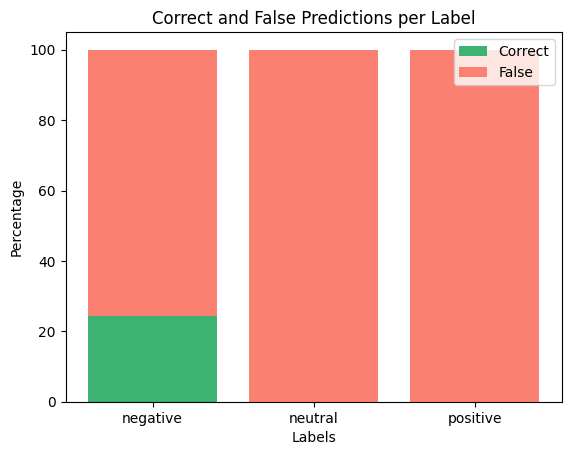

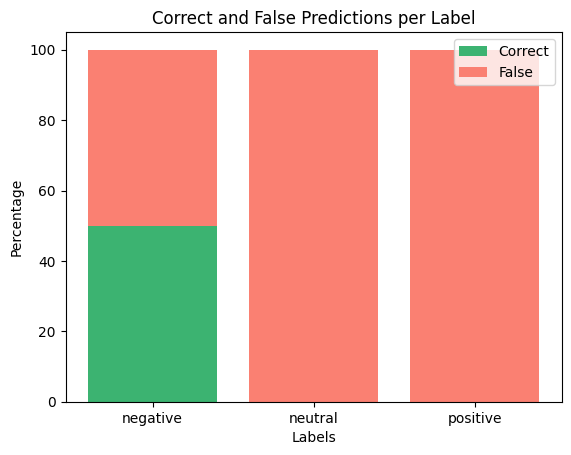

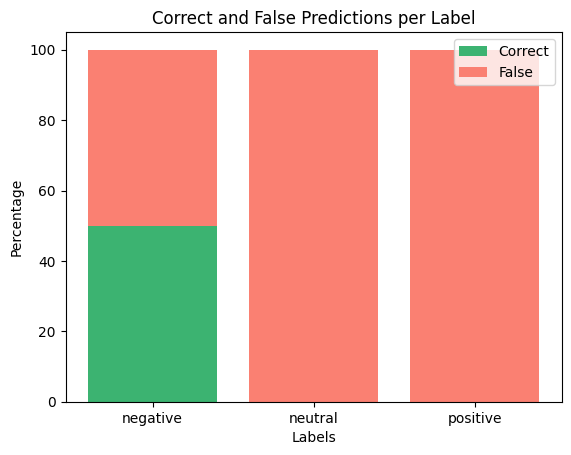

In [12]:
def visualise(golds, preds):
    # from integer labels to text labels
    gold_labels = [idx2lbl[label] for label in golds]
    pred_labels = [idx2lbl[label] for label in preds]
    
    classes = lbl2idx.keys()
    num_classes = np.arange(len(lbl2idx)) # spaced out for pyplot

    # extract counts and calculate percentages of correct and false predictions
    correct_preds_per_label = {label:0 for label in classes}
    false_preds_per_label = {label:0 for label in classes}

    for label in classes:
        for gold, pred in zip(gold_labels, pred_labels):
            if gold == label and gold == pred: # if gold is the current label and a correct prediction
                correct_preds_per_label[label] += 1

            else: 
                false_preds_per_label[label] += 1

    correct_percentages = [(count / len(gold_labels)) * 100 for count in correct_preds_per_label.values()]
    false_percentages = [(count / len(gold_labels)) * 100 for count in false_preds_per_label.values()]

    # design bar chart
    width = 0.8
    plt.bar(num_classes, correct_percentages, width, label = "Correct", color = "mediumseagreen")
    plt.bar(num_classes, false_percentages, width, bottom=correct_percentages, label = "False", color = "salmon")

    plt.xlabel("Labels")
    plt.ylabel("Percentage")
    plt.title("Correct and False Predictions per Label")
    plt.xticks(num_classes, classes)
    plt.legend()

    # plt.tight_layout()
    plt.show()

visualise(eng.labels, eng_preds)
visualise(deu.labels, deu_preds)
visualise(bar.labels, bar_preds)

## Analysing vanilla mBERT for comparison

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda
/home/miriam/Music/trustenv/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Test cases:      66
Fails (rate):    33 (50.0%)

Example fails:
0.6 The weather is not nice.
----
0.6 The picture is not good.
----
0.6 The city is not good.
----


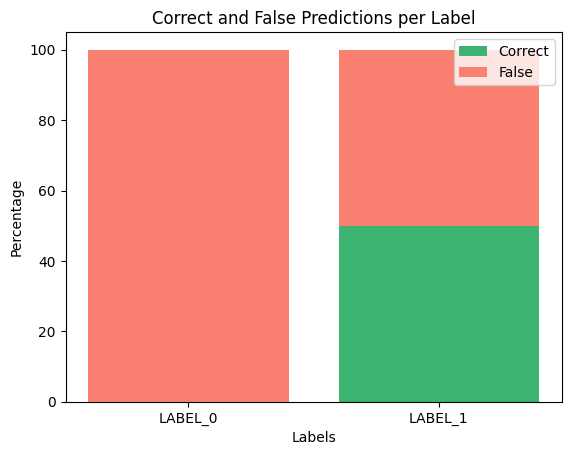

Test cases:      66
Fails (rate):    33 (50.0%)

Example fails:
0.5 Die Seite ist nicht gut.
----
0.5 Die Geschichte ist nicht super.
----
0.6 Das Leben ist nicht schön.
----


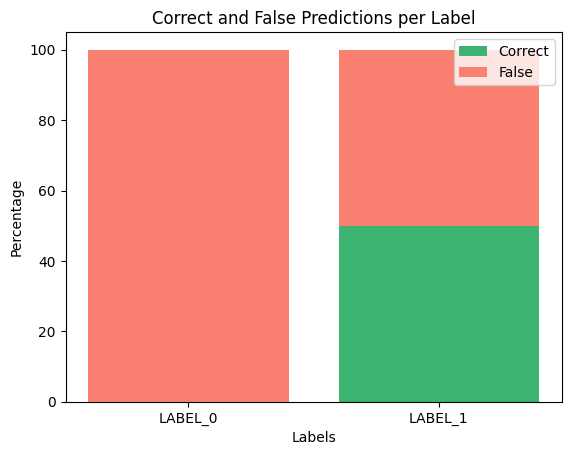

Test cases:      66
Fails (rate):    33 (50.0%)

Example fails:
0.5 Des Buach is ned subba.
----
0.5 Des Buach is ned guad.
----
0.5 De Seitn is ned schee.
----


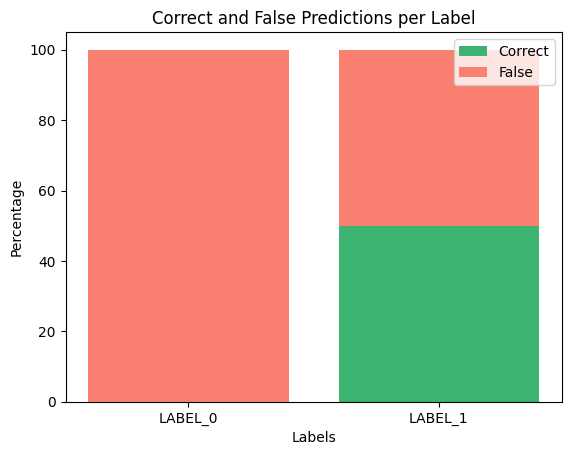

In [1]:
from checklist.editor import Editor
from checklist.test_types import MFT
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import matplotlib.pyplot as plt

# use vanilla mBERT for the same analysis process for comparison

# initialise CheckList Editor objects
eng_editor = Editor() # default language is English
deu_editor = Editor(language="german")

# parallel adjective lists for data creation
eng_pos = ["good", "nice", "great"]
deu_pos = ["gut", "schön", "super"]
bar_pos = ["guad", "schee", "subba"]

eng_neg = ["bad", "boring", "stupid"]
deu_neg = ["schlecht", "langweilig", "blöd"]
bar_neg = ["schlecht", "fad", "bled"]

# parallel noun lists for data creation
# picked from Editor suggestions in such a way that mostly all words are different
eng_noun = ["game", "site", "picture", "book", "story", "man", "world", "city", "time", "weather", "life"]

# standard German and Bavarian examples with determiners to avoid errors
deu_noun = [
    ("Das", "Spiel"), ("Die", "Seite"), ("Das", "Bild"), ("Das", "Buch"), ("Die", "Geschichte"), 
    ("Der", "Mann"), ("Die", "Welt"), ("Die", "Stadt"), ("Die", "Zeit"), ("Das", "Wetter"), ("Das", "Leben")
    ]

# bavarian determiners are with spaces to handle "d'" and "s'" determiners
bar_noun = [
    ("Des ", "Spui"), ("De ", "Seitn"), ("Des ", "Buidl"), ("Des ", "Buach"), ("De ", "Gschicht"), 
    ("Der ", "Mo"), ("D'", "Weid"), ("D'", "Stod"), ("D'", "Zeid"), ("S'", "Weda"), ("S'", "Lebm")
    ] 

# create english data
v_eng = eng_editor.template("The {noun} is not {adj}.", noun=eng_noun, adj=eng_pos, labels=0) # not pos = negative
v_eng += eng_editor.template("The {noun} is not {adj}.", noun=eng_noun, adj=eng_neg, labels=1) # not neg = positive

# create german data
v_deu = deu_editor.template("{detnoun[0]} {detnoun[1]} ist nicht {adj}.", detnoun=deu_noun, adj=deu_pos, labels=0)
v_deu += deu_editor.template("{detnoun[0]} {detnoun[1]} ist nicht {adj}.", detnoun=deu_noun, adj=deu_neg, labels=1)

# create bavarian data
v_bar = deu_editor.template("{detnoun[0]}{detnoun[1]} is ned {adj}.", detnoun=bar_noun, adj=bar_pos, labels=0)
v_bar += deu_editor.template("{detnoun[0]}{detnoun[1]} is ned {adj}.", detnoun=bar_noun, adj=bar_neg, labels=1)


# initialise minimum functionality tests
v_eng_test = MFT(**v_eng, name="English Negations", capability="Negation", description="Litotes sentences to test negation capabilities for vanilla mBERT.")
v_deu_test = MFT(**v_deu, name="Standard German Negations", capability="Negation", description="Litotes sentences to test negation capabilities for vanilla mBERT.")
v_bar_test = MFT(**v_bar, name="Bavarian Negations", capability="Negation", description="Litotes sentences to test negation capabilities for vanilla mBERT.")


# load vanilla mBERT model
v_model_name = "google-bert/bert-base-multilingual-cased"
v_tokenizer = AutoTokenizer.from_pretrained(v_model_name)
v_model = AutoModelForSequenceClassification.from_pretrained(v_model_name)

# initialise pipeline for predictions
device = "cuda" if torch.cuda.is_available() else "cpu"
v_pipe = pipeline("sentiment-analysis", model=v_model, tokenizer=v_tokenizer, device=device, return_all_scores=True)

# make predictions on test data
v_lbl2idx = {"LABEL_0": 0, "LABEL_1": 1}
v_idx2lbl = {0: "LABEL_0", 1: "LABEL_1"}

def v_predict(test):
    # read data and predict
    data = test.to_raw_examples() # necessary for internal CheckList structures (self.result_indexes)
    raw_preds = v_pipe(data)

    preds = []
    confs = []

    # write results in correct CheckList format to a file
    for result in raw_preds:
        negative = result[0]
        positive = result[1]

        max_pred = max([negative, positive], key=lambda x: x["score"])
        max_label = max_pred["label"]

        # prediction, negative_score, neutral_score, positive_score
        preds.append(v_lbl2idx[max_label])
        confs.append(np.array([negative["score"], positive["score"]]))

    return preds, confs

v_eng_preds, v_eng_confs = v_predict(v_eng_test)
v_deu_preds, v_deu_confs = v_predict(v_deu_test)
v_bar_preds, v_bar_confs = v_predict(v_bar_test)


# visualise vanilla mBERT results
def v_visualise(golds, preds):
    # from integer labels to text labels
    gold_labels = [v_idx2lbl[label] for label in golds]
    pred_labels = [v_idx2lbl[label] for label in preds]
    
    classes = v_lbl2idx.keys()
    num_classes = np.arange(len(v_lbl2idx)) # spaced out for pyplot

    # extract counts and calculate percentages of correct and false predictions
    correct_preds_per_label = {label:0 for label in classes}
    false_preds_per_label = {label:0 for label in classes}

    for label in classes:
        for gold, pred in zip(gold_labels, pred_labels):
            if gold == label and gold == pred: # if gold is the current label and a correct prediction
                correct_preds_per_label[label] += 1

            else: 
                false_preds_per_label[label] += 1

    correct_percentages = [(count / len(gold_labels)) * 100 for count in correct_preds_per_label.values()]
    false_percentages = [(count / len(gold_labels)) * 100 for count in false_preds_per_label.values()]
    
    # design bar chart
    width = 0.8
    plt.bar(num_classes, correct_percentages, width, label = "Correct", color = "mediumseagreen")
    plt.bar(num_classes, false_percentages, width, bottom=correct_percentages, label = "False", color = "salmon")

    plt.xlabel("Labels")
    plt.ylabel("Percentage")
    plt.title("Correct and False Predictions per Label")
    plt.xticks(num_classes, classes)
    plt.legend()

    # plt.tight_layout()
    plt.show()


# run eng tests
v_eng_test.run_from_preds_confs(v_eng_preds, v_eng_confs, overwrite=True)
v_eng_test.summary()

v_visualise(v_eng.labels, v_eng_preds)

# run deu tests
v_deu_test.run_from_preds_confs(v_deu_preds, v_deu_confs, overwrite=True)
v_deu_test.summary()

v_visualise(v_deu.labels, v_deu_preds)

# run bar tests
v_bar_test.run_from_preds_confs(v_bar_preds, v_bar_confs, overwrite=True)
v_bar_test.summary()

v_visualise(v_bar.labels, v_bar_preds)